## Imports 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 


if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()

In [3]:
os.chdir(root)
from data_treatment.box_creator import create_binary_box

df = pd.read_csv('database.csv')
df = create_binary_box(df, relative_threshold = 0.05, box_length=5).set_index("Date").dropna(axis = 0)

## Our model 

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

prescale_X = df.drop(columns="Box")
y = df[["Box"]]
#x = (prescale_X - prescale_X.mean())/prescale_X.std()

X_train, X_test, y_train, y_test = train_test_split(prescale_X, y, test_size=0.2)


ridge = make_pipeline(StandardScaler(),LogisticRegression(penalty="l2", solver="newton-cg", C = 0.3))
ridge.fit(X_train, y_train)

score= ridge.score(X_train, y_train)
score

C:\Users\maria\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7245478036175711

### Is our class imbalanced ?

In [19]:
print(len(y_test.loc[y_test['Box']==1])/len(y_test))

0.4318181818181818


### Confusion Matrix

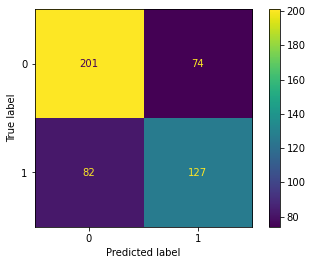

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(ridge, X_test, y_test)


## Getting our precision, recall and f-1 scores

In [21]:
y_pred= ridge.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       275
           1       0.63      0.61      0.62       209

    accuracy                           0.68       484
   macro avg       0.67      0.67      0.67       484
weighted avg       0.68      0.68      0.68       484



### The ROC Curve (receiver operating characteristic)\
plots the true positive rate against the false positive rate \
ie plots sensitivity versus 1- specificity 

In [22]:
y_scores= ridge.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

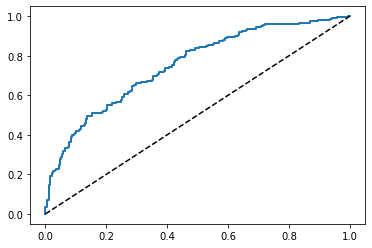

In [23]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label= label)
    plt.plot([0,1], [0,1], 'k--') 
    return 

plot_roc_curve(fpr, tpr)
plt.show()

### Area under the curve 

In [24]:
roc_auc_score(y_test, y_scores)

0.7519443236189647

In [25]:
plt.scatter(x=range(0,X_test.shape[1]), y=abs(ridge.coef_))

AttributeError: 'Pipeline' object has no attribute 'coef_'

In [26]:
import statsmodels.api as sm

log_reg = sm.Logit(y_train, sm.add_constant(X_train))

p_val = log_reg.fit_regularized(L1_wt=0.).pvalues

C:\Users\maria\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\maria\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\maria\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


KeyboardInterrupt: 

In [27]:
X_train.loc[:,(p_val.iloc[1:]<=0.2).values]

,PX_OPEN_VIX_volatility,PX_HIGH_VIX_volatility,PX_LAST_VIX_volatility,OPEN_INT_TOTAL_PUT_VIX_volatility,VOLATILITY_30D_VIX_volatility,VOLATILITY_90D_VIX_volatility,VOLATILITY_360D_VIX_volatility,3MTH_IMPVOL_90.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_90.0%MNY_DF_VIX_volatility,PX_HIGH_SPX_volatility,VOLATILITY_30D_SPX_volatility,VOLATILITY_360D_SPX_volatility,HIST_CALL_IMP_VOL_SPX_volatility,3MTH_IMPVOL_110.0%MNY_DF_SPX_volatility,6MTH_IMPVOL_100.0%MNY_DF_SPX_volatility,6MTH_IMPVOL_105.0%MNY_DF_SPX_volatility,6MTH_IMPVOL_110.0%MNY_DF_SPX_volatility,6MTH_IMPVOL_95.0%MNY_DF_SPX_volatility,12MTH_IMPVOL_110.0%MNY_DF_SPX_volatility,24MTH_IMPVOL_105.0%MNY_DF_SPX_volatility,PX_OPEN_SX5E_volatility,PX_HIGH_SX5E_volatility,PX_LOW_SX5E_volatility,PX_LAST_SX5E_volatility,OPEN_INT_TOTAL_CALL_SX5E_volatility,OPEN_INT_TOTAL_PUT_SX5E_volatility,VOLATILITY_30D_SX5E_volatility,VOLATILITY_10D_SX5E_volatility,VOLATILITY_20D_SX5E_volatility,3MTH_IMPVOL_100.0%MNY_DF_SX5E_volatility,3MTH_IMPVOL_110.0%MNY_DF_SX5E_volatility,6MTH_IMPVOL_105.0%MNY_DF_SX5E_volatility,12MTH_IMPVOL_95.0%MNY_DF_SX5E_volatility,24MTH_IMPVOL_105.0%MNY_DF_SX5E_volatility,24MTH_IMPVOL_110.0%MNY_DF_SX5E_volatility,PX_HIGH_VSTOXX_volatility,PX_LOW_VSTOXX_volatility,VOLATILITY_30D_VSTOXX_volatility,VOLATILITY_260D_VSTOXX_volatility,VOLATILITY_90D_VSTOXX_volatility,VOLATILITY_10D_VSTOXX_volatility,VOLATILITY_20D_VSTOXX_volatility,VOLATILITY_180D_VSTOXX_volatility,QMJ USA_QMJ Factors,US Generic Govt 10 Yr_US Generic Govt 10 Yr,USD SWAP SEMI 30/360 10Y_USD SWAP SEMI 30 360 10Y,ICE LIBOR USD 3 Month_ICE LIBOR USD 3 Month,US Generic Govt 3 Mth_US Generic Govt 3 Mth,PX_VOLUME_CL2,PX_LAST_Euribor3,PX_LAST_Bund10,BAB USA_BAB Factors,BAB Global_BAB Factors,S&P 500 Weeky High_SENTIMENT,Mkt-RF_F-F_Research_Data_5_Factors_2x3_daily,SMB_F-F_Research_Data_5_Factors_2x3_daily,RMW_F-F_Research_Data_5_Factors_2x3_daily,RF_F-F_Research_Data_5_Factors_2x3_daily
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-05-23,18.58,19.80,19.55,215239.0,76.40,99.95,123.44,48.2284,42.8084,1392.20,15.42,17.96,19.29,15.9991,21.4407,19.7130,18.1839,23.2487,19.2016,21.0706,3789.75,3789.75,3725.82,3725.82,19910170.0,24274660.0,15.24,15.08,13.91,21.4656,17.2802,20.8508,22.8270,23.5065,22.5343,21.4603,19.4476,74.05,103.48,107.86,101.77,77.44,101.49,0.001608,3.8425,4.4760,2.64563,1.8482,103610.0,4.857,4.265,0.007501,0.009299,1396.20,-1.24,0.05,-0.26,0.008
2019-08-26,20.34,21.33,19.32,2076653.0,199.58,152.01,131.51,67.6262,54.6006,2879.27,20.36,15.67,17.81,12.0774,17.6521,14.6439,12.4647,20.2563,13.7391,16.5523,3329.73,3360.93,3318.33,3348.84,12925156.0,23941948.0,18.98,19.50,21.93,18.0838,12.7881,14.7349,17.0198,15.1866,14.7192,21.9047,19.8234,147.13,108.04,115.82,157.81,172.21,106.32,0.000222,1.5351,1.4557,2.14438,1.9764,94842.0,-0.418,-0.666,0.002819,0.001781,2931.00,1.08,-0.04,0.19,0.007
2011-06-21,19.46,19.46,18.86,1148437.0,111.10,115.34,116.25,56.8911,45.6182,1297.62,14.68,16.90,16.38,12.5934,18.6553,16.7332,15.1441,20.7336,17.0752,19.6390,2760.67,2801.99,2760.67,2801.99,15422540.0,19025050.0,17.96,22.54,19.10,21.3340,17.0135,20.0216,22.6863,22.8637,21.7411,25.3344,23.9414,82.59,88.74,101.58,97.89,83.37,95.09,-0.006764,2.9835,3.1245,0.24550,0.0203,323911.0,1.520,2.979,-0.004793,-0.004601,1294.54,1.52,0.95,-0.27,0.000
2014-10-09,15.64,19.38,18.76,2276136.0,131.60,124.94,104.57,67.2686,56.7537,1967.68,13.51,11.08,15.99,11.1630,15.8586,14.2551,12.4846,18.1240,14.3317,17.5821,3071.34,3090.45,3028.32,3042.45,12670440.0,16958660.0,16.32,20.47,17.84,18.4198,15.3148,16.8290,19.1580,18.3134,17.8430,20.9756,19.3275,92.51,98.57,105.23,94.93,106.27,101.81,0.008289,2.3133,2.4515,0.22910,0.0051,164887.0,0.079,0.906,0.004141,0.005594,1985.17,-2.17,-0.47,0.41,0.000
2015-05-07,15.48,15.97,15.13,1942874.0,95.79,113.29,116.10,59.6995,52.8286,2092.90,10.11,11.83,13.63,9.3443,15.1826,12.7261,10.7008,17.6765,13.2881,17.3515,3538.02,3567.08,3484.07,3556.21,12421800.0,17708880.0,18.00,22.68,19.15,20.7980,17.8371,19.0851,2

In [28]:
X_train

,PX_OPEN_VIX_volatility,PX_HIGH_VIX_volatility,PX_LOW_VIX_volatility,PX_LAST_VIX_volatility,VOLUME_TOTAL_CALL_VIX_volatility,PUT_CALL_VOLUME_RATIO_CUR_DAY_VIX_volatility,VOLUME_TOTAL_PUT_VIX_volatility,TOT_OPT_VOLUME_CUR_DAY_VIX_volatility,OPEN_INT_TOTAL_CALL_VIX_volatility,OPEN_INT_TOTAL_PUT_VIX_volatility,VOLATILITY_30D_VIX_volatility,VOLATILITY_260D_VIX_volatility,VOLATILITY_90D_VIX_volatility,VOLATILITY_60D_VIX_volatility,VOLATILITY_360D_VIX_volatility,VOLATILITY_10D_VIX_volatility,VOLATILITY_20D_VIX_volatility,VOLATILITY_180D_VIX_volatility,HIST_CALL_IMP_VOL_VIX_volatility,3MTH_IMPVOL_100.0%MNY_DF_VIX_volatility,3MTH_IMPVOL_105.0%MNY_DF_VIX_volatility,3MTH_IMPVOL_110.0%MNY_DF_VIX_volatility,3MTH_IMPVOL_90.0%MNY_DF_VIX_volatility,3MTH_IMPVOL_95.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_100.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_105.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_110.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_90.0%MNY_DF_VIX_volatility,6MTH_IMPVOL_95.0%MNY_DF_VIX_volatility,PX_OPEN_SPX_volatility,PX_HIGH_SPX_volatility,PX_LOW_SPX_volatility,PX_LAST_SPX_volatility,PX_VOLUME_SPX_volatility,VOLUME_TOTAL_CALL_SPX_volatility,PUT_CALL_VOLUME_RATIO_CUR_DAY_SPX_volatility,VOLUME_TOTAL_PUT_SPX_volatility,TOT_OPT_VOLUME_CUR_DAY_SPX_volatility,OPEN_INT_TOTAL_CALL_SPX_volatility,OPEN_INT_TOTAL_PUT_SPX_volatility,...,US Generic Govt 10 Yr_US Generic Govt 10 Yr,USD SWAP SEMI 30/360 10Y_USD SWAP SEMI 30 360 10Y,ICE LIBOR USD 3 Month_ICE LIBOR USD 3 Month,US Generic Govt 3 Mth_US Generic Govt 3 Mth,USD SWAP OIS 3M_USD SWAP OIS 3M,PX_OPEN_CL1,PX_HIGH_CL1,PX_LOW_CL1,PX_LAST_CL1,PX_VOLUME_CL1,PX_OPEN_CL2,PX_HIGH_CL2,PX_LOW_CL2,PX_LAST_CL2,PX_VOLUME_CL2,PX_OPEN_CL3,PX_HIGH_CL3,PX_LOW_CL3,PX_LAST_CL3,PX_VOLUME_CL3,PX_LAST_Euribor3,PX_LAST_Bund10,BAB USA_BAB Factors,BAB Global_BAB Factors,Bullish_SENTIMENT,Neutral_SENTIMENT,Bearish_SENTIMENT,Bullish 8-week Mov Avg_SENTIMENT,Bull-Bear Spread_SENTIMENT,S&P 500 Weeky High_SENTIMENT,S&P 500 Weekly Low_SENTIMENT,S&P 500 Weekly Close_SENTIMENT,ST_Rev_F-F_ST_Reversal_Factor_daily,Mkt-RF_F-F_Research_Data_5_Factors_2x3_daily,SMB_F-F_Research_Data_5_Factors_2x3_daily,HML_F-F_Research_Data_5_Factors_2x3_daily,RMW_F-F_Research_Data_5_Factors_2x3_daily,CMA_F-F_Research_Data_5_Factors_2x3_daily,RF_F-F_Research_Data_5_Factors_2x3_daily,Mom _F-F_Momentum_Factor_daily
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-05-23,18.58,19.80,18.38,19.55,73803.0,0.3546,26171.0,99974.0,696352.0,215239.0,76.40,121.63,99.95,99.90,123.44,77.47,84.12,115.54,64.16,50.7398,52.1728,53.5542,48.2284,49.2285,44.2586,45.1445,46.0229,42.8084,43.5029,1392.20,1392.20,1373.72,1375.93,955730237,180108.0,1.8133,326583.0,506691.0,4169379.0,7047278.0,...,3.8425,4.4760,2.64563,1.8482,1.9835,130.75,133.71,130.16,132.19,321344.0,130.83,133.70,130.28,132.24,103610.0,130.75,133.51,130.28,132.03,52179.0,4.857,4.265,0.007501,0.009299,0.463000,0.194400,0.342600,0.446325,0.120400,1396.20,1390.70,1390.71,-0.04,-1.24,0.05,-0.35,-0.26,-0.10,0.008,0.84
2019-08-26,20.34,21.33,19.06,19.32,205435.0,0.4357,89516.0,294951.0,5643209.0,2076653.0,199.58,134.79,152.01,148.40,131.51,203.66,237.59,130.86,89.60,72.8025,75.2878,76.9570,67.6262,70.1864,57.8139,59.2406,60.7027,54.6006,56.4598,2866.70,2879.27,2856.00,2878.38,463912564,417645.0,2.2069,921706.0,1339351.0,5444830.0,11599901.0,...,1.5351,1.4557,2.14438,1.9764,1.8750,53.25,55.26,52.96,53.64,679022.0,53.16,55.06,52.84,53.50,94842.0,52.84,54.72,52.60,53.24,79259.0,-0.418,-0.666,0.002819,0.001781,0.266355,0.336449,0.397196,0.305428,-0.130841,2931.00,2825.51,2924.43,-0.23,1.08,-0.04,-0.18,0.19,-0.15,0.007,0.40
2011-06-21,19.46,19.46,17.72,18.86,197839.0,0.2760,54613.0,252452.0,2713026.0,1148437.0,111.10,97.92,115.34,95.54,116.25,132.76,115.51,102.50,78.33,63.9020,66.8451,69.4875,56.8911,60.6117,48.9664,50.5269,52.0050,45.6182,47.3268,1278.40,1297.62,1278.40,1295.52,653996548,310657.0,1.5746,489171.0,799828.0,4383958.0,7633379.0,...,2.9835,3.1245,0.24550,0.0203,0.1210,93.49,94.74,